## Fontes das funções

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, coluna_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)
    
    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')
    
    if coluna_alvo not in df_numerico.columns:
        raise ValueError(f"A coluna '{coluna_alvo}' não é numérica ou não está no dataset.")

    # Calcula a correlação da coluna alvo com todas as outras
    correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

    # Ordena por valor da correlação
    correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

    # Plotando o gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(f'Correlação com a coluna "{coluna_alvo}"')
    plt.xlabel('Coeficiente de Correlação de Pearson')
    plt.ylabel('Colunas')
    plt.tight_layout()
    plt.show()

def substituir_nulos_por_mediana(caminho_entrada, caminho_saida, coluna):
    # Lê os dados
    df = pd.read_csv(caminho_entrada)

    # Conta o número de valores nulos antes da substituição
    nulos_originais = df[coluna].isnull().sum()

    # Substitui nulos pela mediana
    coluna_median = df[coluna].median()
    df[coluna].fillna(coluna_median, inplace=True)

    # Conta o número de valores modificados
    nulos_modificados = nulos_originais - df[coluna].isnull().sum()

    # Calcula a média dos valores substituídos
    media_substituida = df[coluna].loc[df[coluna] == coluna_median].mean()

    # Salva os dados atualizados em outro arquivo
    df.to_csv(caminho_saida, index=False)

    # Exibe os resultados
    print(f'Número de valores nulos em "{coluna}" antes: {nulos_originais}')
    print(f'Número de valores modificados em "{coluna}": {nulos_modificados}')
    print(f'Média dos valores substituídos em "{coluna}": {media_substituida}')

def substituir_nulos_por_correlacao(caminho_entrada, caminho_saida, coluna_alvo, coluna_referencia, limite_correlacao=0.7):
    df = pd.read_csv(caminho_entrada)

    # Validação das colunas
    if coluna_alvo not in df.columns or coluna_referencia not in df.columns:
        raise ValueError(f"Colunas '{coluna_alvo}' e/ou '{coluna_referencia}' não existem no arquivo.")

    # Força conversão para numérico
    df[coluna_alvo] = pd.to_numeric(df[coluna_alvo], errors='coerce')
    df[coluna_referencia] = pd.to_numeric(df[coluna_referencia], errors='coerce')

    # Diagnóstico inicial
    print(f"[INFO] Tipos - {coluna_alvo}: {df[coluna_alvo].dtype}, {coluna_referencia}: {df[coluna_referencia].dtype}")

    nulos_antes = df[coluna_alvo].isnull().sum()
    mediana_alvo = df[coluna_alvo].median()
    corr = df[[coluna_alvo, coluna_referencia]].corr().iloc[0, 1]

    print(f"[INFO] Correlação entre '{coluna_alvo}' e '{coluna_referencia}': {corr:.2f}")
    print(f"[INFO] Mediana de '{coluna_alvo}': {mediana_alvo}")

    if pd.isnull(mediana_alvo):
        print(f"[ALERTA] Mediana de '{coluna_alvo}' é NaN. Substituições por mediana podem falhar.")

    # Substituição
    preenchidos = 0
    for idx, row in df.iterrows():
        val_alvo = row[coluna_alvo]
        val_ref = row[coluna_referencia]

        if pd.isnull(val_alvo):
            if not pd.isnull(val_ref) and abs(corr) >= limite_correlacao:
                df.at[idx, coluna_alvo] = val_ref
            else:
                df.at[idx, coluna_alvo] = mediana_alvo
            preenchidos += 1

    # Salva
    df.to_csv(caminho_saida, index=False)

    # Resultado final
    nulos_depois = df[coluna_alvo].isnull().sum()
    print(f"\n[RESULTADO] '{coluna_alvo}': Nulos antes: {nulos_antes}, corrigidos: {preenchidos}, restantes: {nulos_depois}")

def preencher_nulos_com_base_em_correlacao(caminho_entrada, caminho_saida, col1, col2, limite_correlacao):
    df = pd.read_csv(caminho_entrada)

    # Calcula correlação
    corr = df[[col1, col2]].corr().iloc[0, 1]
    print(f"[INFO] Correlação entre '{col1}' e '{col2}': {corr:.2f}")

    # Calcula medianas
    mediana1 = df[col1].median()
    mediana2 = df[col2].median()

    # Contadores
    col1_corr = col1_mediana = 0
    col2_corr = col2_mediana = 0

    # Preenchimento
    for idx, row in df.iterrows():
        val1 = row[col1]
        val2 = row[col2]

        if pd.isnull(val1):
            if abs(corr) >= limite_correlacao and not pd.isnull(val2):
                df.at[idx, col1] = val2
                col1_corr += 1
            else:
                df.at[idx, col1] = mediana1
                col1_mediana += 1

        if pd.isnull(val2):
            if abs(corr) >= limite_correlacao and not pd.isnull(val1):
                df.at[idx, col2] = val1
                col2_corr += 1
            else:
                df.at[idx, col2] = mediana2
                col2_mediana += 1

    # Salvar resultado
    df.to_csv(caminho_saida, index=False)

    # Resultados detalhados
    print(f"\n[RESULTADO - {col1}]")
    print(f"Preenchidos por correlação: {col1_corr}")
    print(f"Preenchidos por mediana:    {col1_mediana}")

    print(f"\n[RESULTADO - {col2}]")
    print(f"Preenchidos por correlação: {col2_corr}")
    print(f"Preenchidos por mediana:    {col2_mediana}")

def preencher_com_knn(caminho_entrada, caminho_saida, coluna_alvo, colunas_auxiliares, n_vizinhos=5):
    # Carrega os dados
    df = pd.read_csv(caminho_entrada)

    # Conta nulos antes
    nulos_antes = df[coluna_alvo].isnull().sum()

    # Remove linhas com nulos nas colunas auxiliares
    df_aux = df[colunas_auxiliares + [coluna_alvo]].dropna(subset=colunas_auxiliares)

    # Divide entre linhas com e sem alvo
    df_treino = df_aux[df_aux[coluna_alvo].notnull()]
    df_predicao = df_aux[df_aux[coluna_alvo].isnull()]

    if df_predicao.empty:
        print("[INFO] Nenhum valor nulo para preencher na coluna alvo.")
        df.to_csv(caminho_saida, index=False)
        return

    # Prepara treino
    X_train = df_treino[colunas_auxiliares]
    y_train = df_treino[coluna_alvo]

    # Prepara predição
    X_pred = df_predicao[colunas_auxiliares]

    # Modelo KNN
    model = KNeighborsRegressor(n_neighbors=n_vizinhos)
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_pred)

    # Preenche os nulos no dataframe original
    df.loc[df[coluna_alvo].isnull() & df[colunas_auxiliares].notnull().all(axis=1), coluna_alvo] = y_pred

    # Pós-preenchimento
    nulos_depois = df[coluna_alvo].isnull().sum()
    nulos_preenchidos = nulos_antes - nulos_depois
    media_preenchida = y_pred.mean()

    # Salva resultado
    df.to_csv(caminho_saida, index=False)

    # Relatório
    print(f"[RELATÓRIO - {coluna_alvo}]")
    print(f"Total de nulos antes:    {nulos_antes}")
    print(f"Nulos preenchidos:       {nulos_preenchidos}")
    print(f"Nulos restantes:         {nulos_depois}")
    print(f"Média dos valores previstos: {media_preenchida:.2f}\n")

def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel('Número de Substituições')
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel('Número de Substituições')
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

## Vamos ver o histograma de ocorrências (que temos disponível)

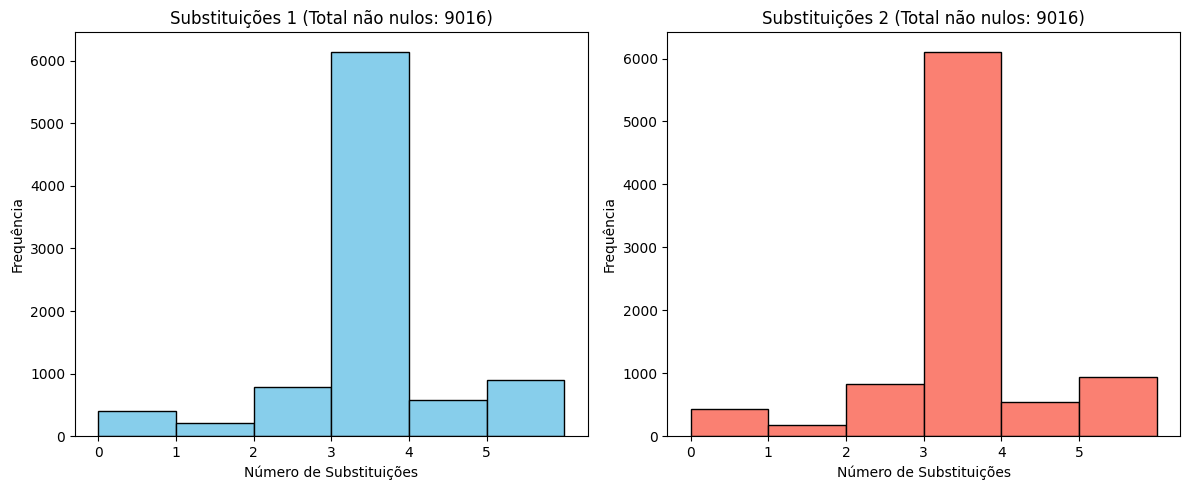

In [42]:
plotar_histogramas_duplos('saida_sem_outliers.csv', 'Substituições 1', 'Substituições 2')

Com os dados que temos, percebemos que geralmente acontecem 3 substituições por jogo.

## Vamos dar uma olhada nas correlações!

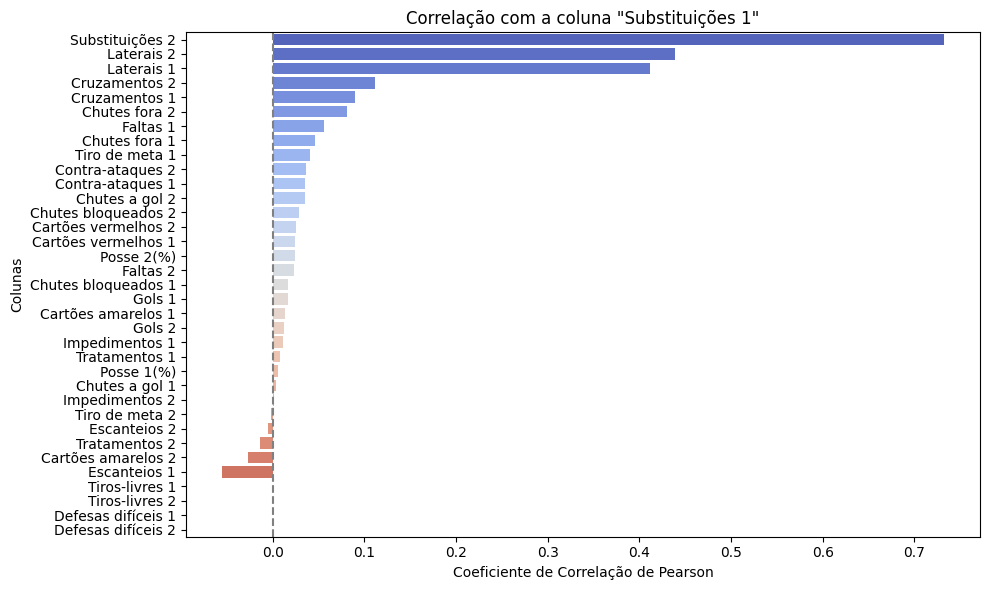

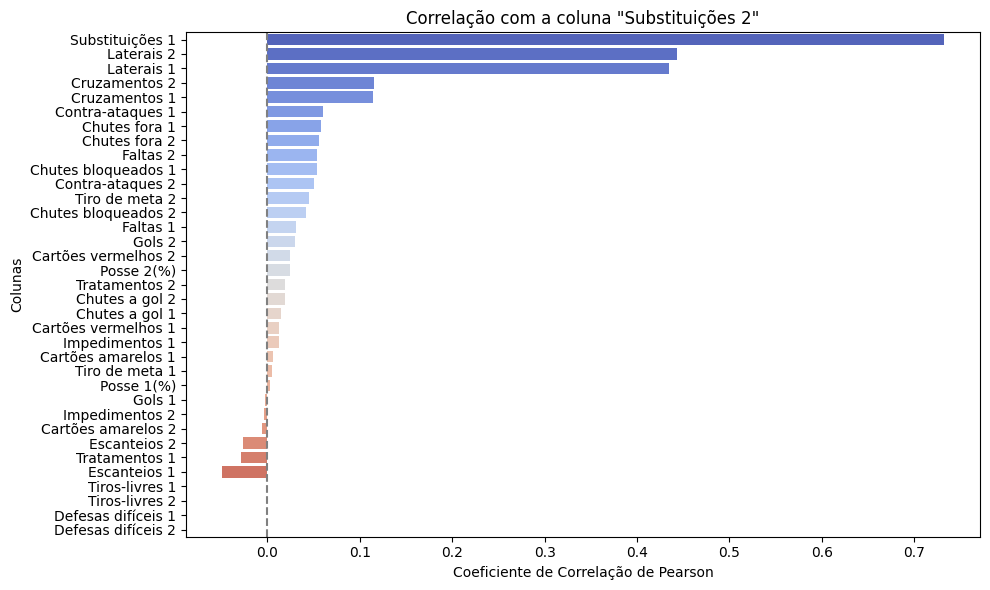

In [43]:
grafico_correlacoes('saida_sem_outliers.csv', 'Substituições 1')
grafico_correlacoes('saida_sem_outliers.csv', 'Substituições 2')

In [44]:
df = pd.read_csv("saida_sem_outliers.csv")
nulos_abs = df.isnull().sum()
nulos_pct = (nulos_abs / len(df)) * 100
resumo_nulos = pd.DataFrame({
    'Nulos absolutos': nulos_abs,
    '% do total': nulos_pct.round(2)
})
print(resumo_nulos)

                     Nulos absolutos  % do total
Chutes a gol 1                  1505        5.62
Chutes a gol 2                  1505        5.62
Impedimentos 1                  2740       10.22
Impedimentos 2                  2740       10.22
Escanteios 1                    2310        8.62
Escanteios 2                    2310        8.62
Chutes fora 1                   2305        8.60
Chutes fora 2                   2305        8.60
Faltas 1                        2304        8.60
Faltas 2                        2304        8.60
Cartões amarelos 1                 0        0.00
Cartões amarelos 2                 0        0.00
Cartões vermelhos 1                0        0.00
Cartões vermelhos 2                0        0.00
Cruzamentos 1                  18250       68.09
Cruzamentos 2                  18250       68.09
Laterais 1                     12230       45.63
Laterais 2                     12230       45.63
Chutes bloqueados 1            18404       68.67
Chutes bloqueados 2 

As maiores correlações são a Substituição do time oponente e dos números de Laterais 2 e 1

## Vamos tentar substituir usando KNN

### Como funciona?

---
KNN (K-Nearest Neighbors) é baseado em similaridade. Usamos os vizinhos próximos do dado para usar essas informações para prever um valor. De forma geral, ele copia os resultados dos vizinhos parecidos com ele. No caso em questão usaremos os seguintes vizinhos:

- Substituições ❌
- Laterais ✅
- Cruzamentos ❌

Como cruzamentos está 68% nula, vamos evitar essa coluna. Vamos evitar usar a coluna das substituições pois elas estão interligadas. Geralmente uma substituição do time 1 leva a substituição do time 2 e vice versa.

In [49]:
colunas_correlacionadas_1 = ['Laterais 1', 'Laterais 2']
preencher_com_knn('saida_sem_outliers.csv', 'saida_com_valores_substituidos.csv', 'Substituições 1', colunas_correlacionadas_1)
colunas_correlacionadas_2 = ['Laterais 1', 'Laterais 2']
preencher_com_knn('saida_com_valores_substituidos.csv', 'saida_com_valores_substituidos.csv', 'Substituições 2', colunas_correlacionadas_2)

[RELATÓRIO - Substituições 1]
Total de nulos antes:    17786
Nulos preenchidos:       9171
Nulos restantes:         8615
Média dos valores previstos: 3.67

[RELATÓRIO - Substituições 2]
Total de nulos antes:    17786
Nulos preenchidos:       9171
Nulos restantes:         8615
Média dos valores previstos: 3.71



Podemos ver que uma parte considerável dos nulos não foi preenchido, isso porque Laterais tem 45% dos dados nulos. 

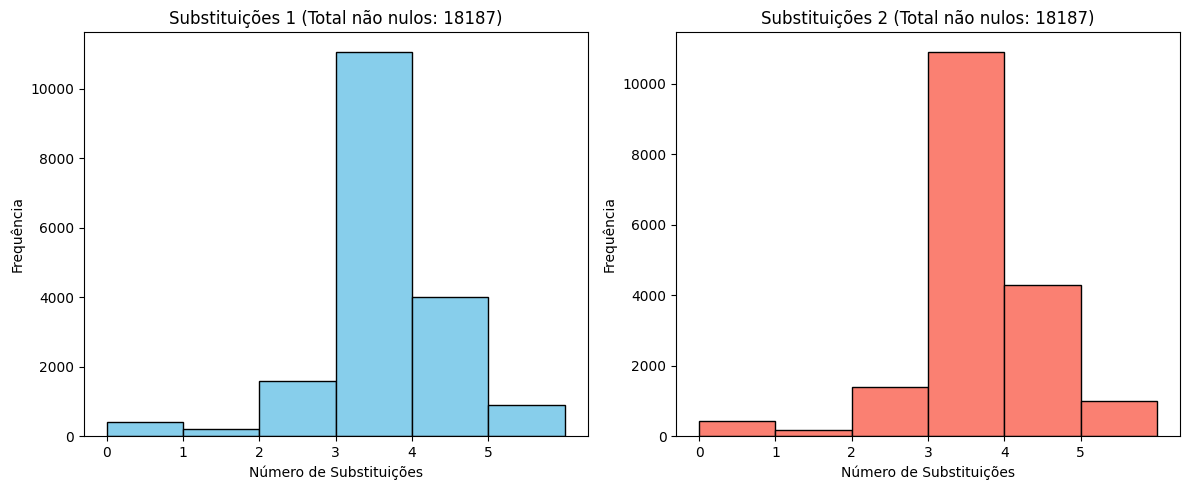

In [46]:
plotar_histogramas_duplos('saida_com_valores_substituidos.csv', 'Substituições 1', 'Substituições 2')

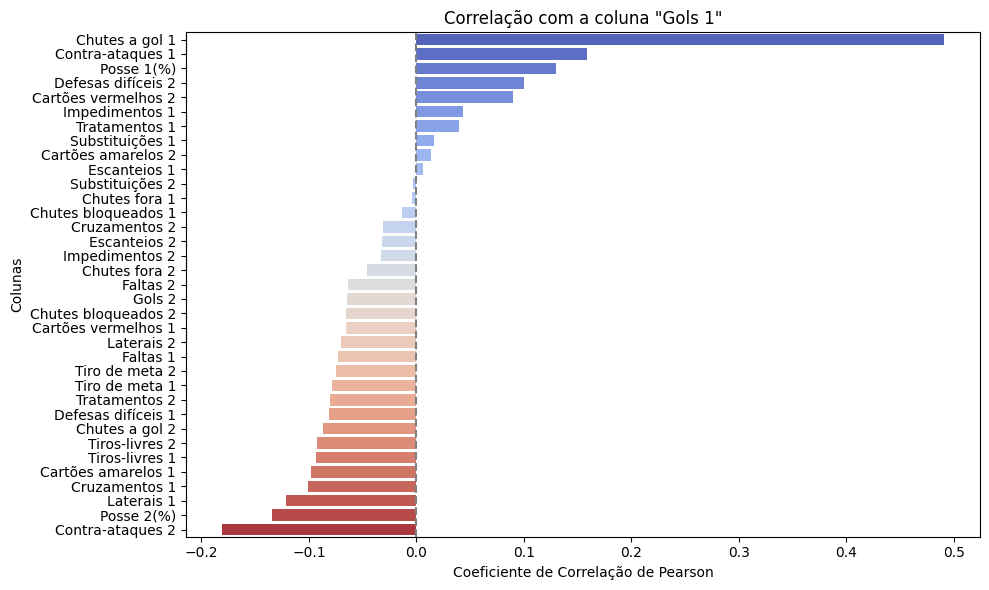

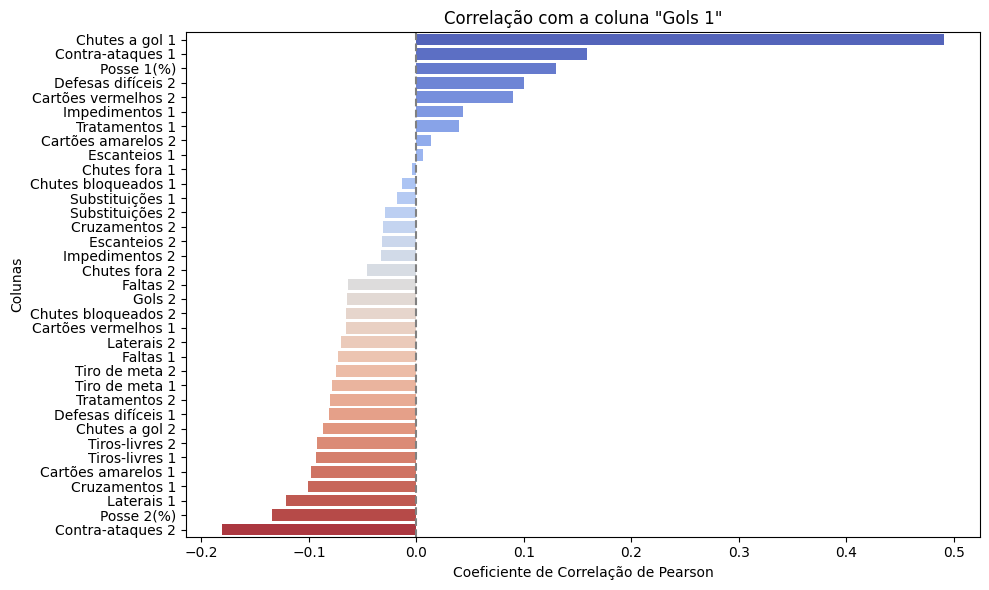

In [47]:
grafico_correlacoes('saida_sem_outliers.csv', 'Gols 1')
grafico_correlacoes('saida_com_valores_substituidos.csv', 'Gols 1')

# Conclusão

Podemos ver que a correlação de Gols não foi alterada praticamente. E além disso, vimos que o impacto dessa coluna com Gols já era baixo e se manteve assim. Nos levando a crer que Substituições são irrelevantes para um modelo de previsão de resultados de gols. Além disso, como os resultados estão concentrados entre 3 e 4 é praticamente irrelevante o uso dessa coluna. Existe uma justificativa para os valores se glomerarem em 3 substituições, até 2022 o limite de substituições no jogo era 3. Depois disso, aumentaram o limite à 5.